In [1]:
!pip install torchinfo --quiet
!pip install matplotlib --quiet
!pip install imageio --quiet

In [2]:
from torchinfo import summary
import torch.nn as nn
import torch
import os
import matplotlib.pyplot as plt
# import imageio
# from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F
import torchvision
import multiprocessing
import torchvision.transforms as T

In [3]:
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
%cd /content/drive/MyDrive/ERA_v1/Session18/dev2

/content/drive/MyDrive/ERA_v1/Session18/dev2


In [6]:
from unet import UNet
from dataset import get_dataset, get_dataloaders
from train import get_loss_function, train, test, run_training
from utils import show_sample_images, plot_losses, show_image_results

In [7]:
unet_model = UNet(in_channels=3, out_channels=3, stride=True, conv_transpose=False)
summary(model= unet_model, input_size=(32,3,128,128), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
UNet (UNet)                              [32, 3, 128, 128]    [32, 3, 128, 128]    --                   True
├─ContractingBlock (contract1)           [32, 3, 128, 128]    [32, 32, 64, 64]     --                   True
│    └─Conv2d (conv1)                    [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
│    └─BatchNorm2d (bn1)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu1)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (conv2)                    [32, 32, 128, 128]   [32, 32, 128, 128]   9,248                True
│    └─BatchNorm2d (bn2)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu2)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (str

In [8]:
train_data_path, train_dataset, test_data_path, test_dataset = get_dataset(dir="./data")

100%|██████████| 791918971/791918971 [00:39<00:00, 20022711.37it/s]


Extracting data/OxfordPets/train/oxford-iiit-pet/images.tar.gz to data/OxfordPets/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7966841.24it/s] 


Extracting data/OxfordPets/train/oxford-iiit-pet/annotations.tar.gz to data/OxfordPets/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:40<00:00, 19347682.34it/s]


Extracting data/OxfordPets/test/oxford-iiit-pet/images.tar.gz to data/OxfordPets/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 8070026.55it/s] 


Extracting data/OxfordPets/test/oxford-iiit-pet/annotations.tar.gz to data/OxfordPets/test/oxford-iiit-pet


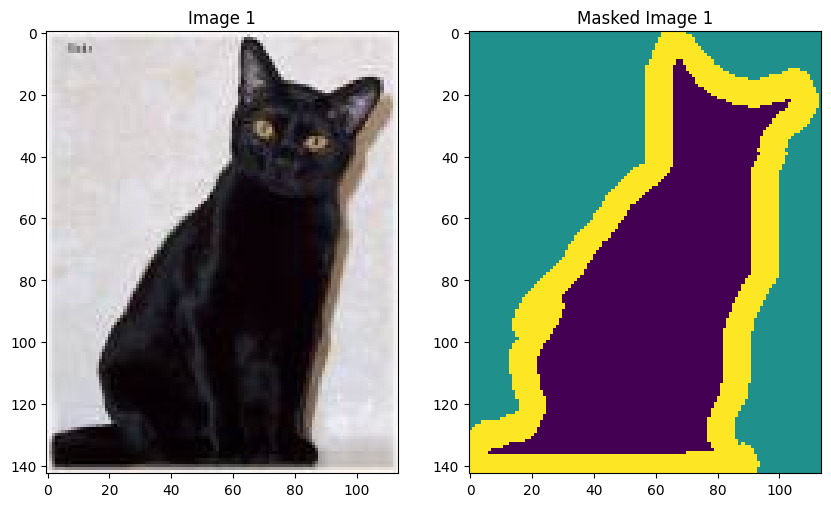

In [9]:
show_sample_images(train_dataset)

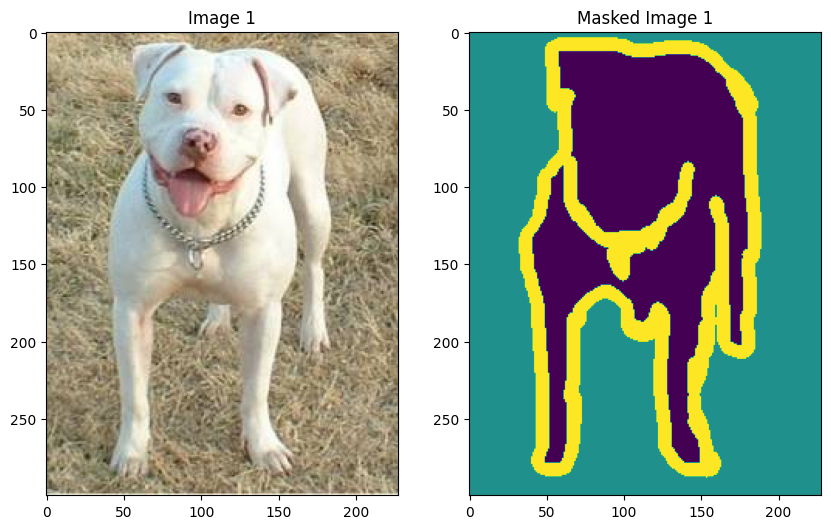

In [9]:
show_sample_images(train_dataset)

Text(0.5, 1.0, 'Masked Image 1')

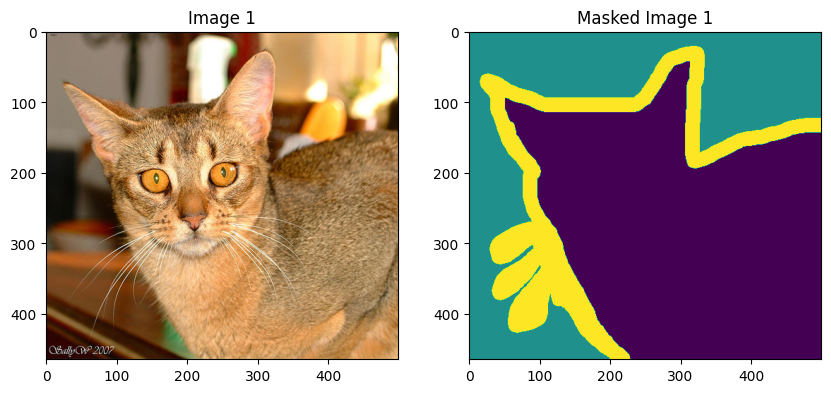

In [ ]:
# sample image
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(train_dataset[2][0])
arr[0].set_title('Image '+ str(1))
arr[1].imshow(train_dataset[2][1])
arr[1].set_title('Masked Image '+ str(1))
# arr[2].imshow(train_dataset[0][2])
# arr[2].set_title('Background '+ str(2))

In [10]:
train_dataloader, test_dataloader = get_dataloaders(train_data_path, test_data_path)

In [11]:
# check the shape
(train_data_inputs, train_data_targets) = next(iter(train_dataloader))
train_data_inputs.shape, train_data_targets.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16, 1, 128, 128]))

In [12]:
EPOCHS = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Training the UNET MODEL for the model combination - MaxPooling + Transpose + Cross Entropy Loss

In [13]:
unet_model = UNet(in_channels=3, out_channels=3, stride=False, conv_transpose=True).to(device)
optimizer = torch.optim.Adam(params = unet_model.parameters(),lr=0.001)

print(summary(model= unet_model, input_size = (32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
                                               col_width=20,
                                               row_settings=["var_names"]))

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
UNet (UNet)                                   [32, 3, 128, 128]    [32, 3, 128, 128]    --                   True
├─ContractingBlock (contract1)                [32, 3, 128, 128]    [32, 32, 64, 64]     4,128                True
│    └─Conv2d (conv1)                         [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
│    └─BatchNorm2d (bn1)                      [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu1)                           [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (conv2)                         [32, 32, 128, 128]   [32, 32, 128, 128]   9,248                True
│    └─BatchNorm2d (bn2)                      [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu2)                           [32, 32, 128, 128]   [32, 32, 128, 128]

In [14]:
loss_type='CE'

In [15]:
train_losses, test_losses = run_training(unet_model, loss_type, EPOCHS, train_dataloader, test_dataloader, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1   | train_loss: 0.6179 | test_loss: 0.5673 
Epoch: 2   | train_loss: 0.4729 | test_loss: 0.4597 
Epoch: 3   | train_loss: 0.4145 | test_loss: 0.4021 
Epoch: 4   | train_loss: 0.3688 | test_loss: 0.3983 
Epoch: 5   | train_loss: 0.3446 | test_loss: 0.3797 
Epoch: 6   | train_loss: 0.3207 | test_loss: 0.3363 
Epoch: 7   | train_loss: 0.3081 | test_loss: 0.3791 
Epoch: 8   | train_loss: 0.2898 | test_loss: 0.3374 
Epoch: 9   | train_loss: 0.2789 | test_loss: 0.3332 
Epoch: 10   | train_loss: 0.2625 | test_loss: 0.3374 
Epoch: 11   | train_loss: 0.2461 | test_loss: 0.2999 
Epoch: 12   | train_loss: 0.2404 | test_loss: 0.3449 
Epoch: 13   | train_loss: 0.2368 | test_loss: 0.3022 
Epoch: 14   | train_loss: 0.2281 | test_loss: 0.2984 
Epoch: 15   | train_loss: 0.2071 | test_loss: 0.2870 
Epoch: 16   | train_loss: 0.2010 | test_loss: 0.3014 
Epoch: 17   | train_loss: 0.2028 | test_loss: 0.3056 
Epoch: 18   | train_loss: 0.2018 | test_loss: 0.3038 
Epoch: 19   | train_loss: 0.1779 | te

In [17]:
plot_losses(train_losses, test_losses, title = "UNET Model:: Max Pooling + Convolution Transpose + Cross Entropy Loss")

TypeError: ignored

### Training the UNET MODEL for the model combination - MaxPooling + Transpose + Dice Loss

In [ ]:
unet_model2 = UNet(in_channels=3, out_channels=3, stride=False, conv_transpose=True).to(device)
optimizer2 = torch.optim.Adam(params = unet_model2.parameters(),lr=0.001)
print(summary(model= unet_model2, input_size=(32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
                                                                        col_width=20,
                                                                        row_settings=["var_names"]))

In [ ]:
loss_type2='Dice_Loss'

In [ ]:
train_losses2, test_losses2 = run_training(unet_model2, loss_type2, EPOCHS, train_dataloader, test_dataloader, device)

In [ ]:
plot_losses(train_losses2, test_losses2, title = "UNET Model:: Max Pooling + Convolution Transpose + Dice Loss")

### Training the UNET MODEL for the model combination - Strided Convolution + Transpose + Cross Entropy Loss

In [ ]:
unet_model3 = UNet(in_channels=3, out_channels=3, stride=True, conv_transpose=True).to(device)
optimizer3 = torch.optim.Adam(params = unet_model3.parameters(), lr=0.001)
print(summary(model= unet_model3, input_size=(32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
                                                                        col_width=20,
                                                                        row_settings=["var_names"]))

In [ ]:
train_losses3, test_losses3 = run_training(unet_model3, loss_type, EPOCHS, train_dataloader, test_dataloader, device)

In [ ]:
plot_losses(train_losses3, test_losses3, title = "UNET Model:: Strided Convolution + Convolution Transpose + Cross Entropy Loss")

### Training the UNET MODEL for the model combination - Strided Convolution + UpSampling + Dice Loss

In [ ]:
unet_model4 = UNet(in_channels=3, out_channels=3, stride=True, conv_transpose=False).to(device)
optimizer4 = torch.optim.Adam(params = unet_model4.parameters(), lr=0.001)
print(summary(model= unet_model4, input_size=(32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
                                                                        col_width=20,
                                                                        row_settings=["var_names"]))

In [ ]:
train_losses4, test_losses4 = run_training(unet_model4, loss_type2, EPOCHS, train_dataloader, test_dataloader, device)

In [ ]:
plot_losses(train_losses4, test_losses4, title = "UNET Model:: Strided Convolution + UpSampling + Dice Loss")

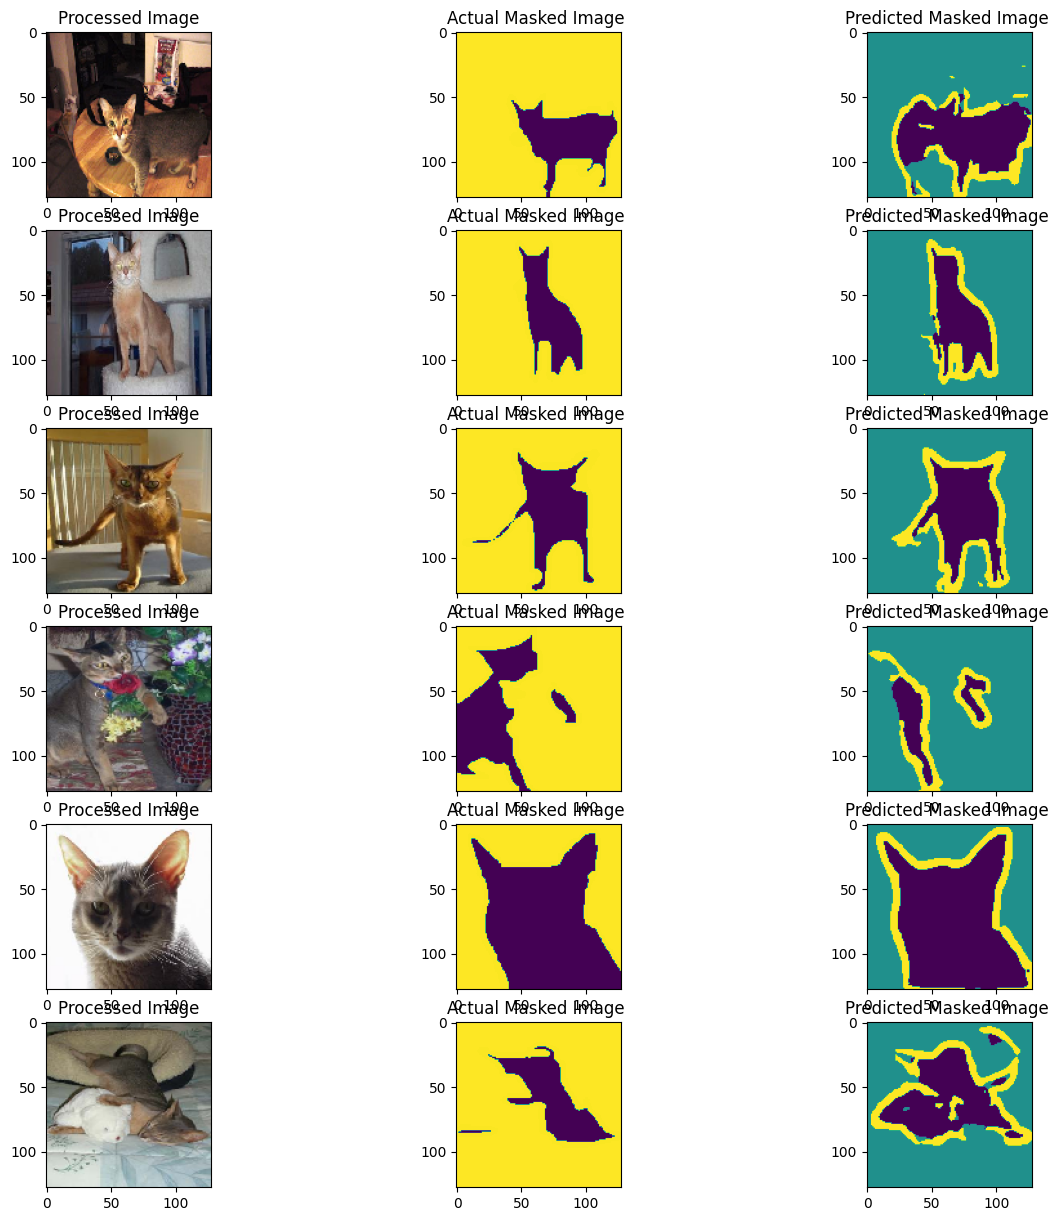

In [ ]:
def VisualizeResults(unet_model):
    unet_model.eval()
    unet_model.to('cpu')
    transform = T.ToPILImage()
    (test_pets_inputs, test_pets_targets) = next(iter(test_dataloader))
    fig, arr = plt.subplots(6, 3, figsize=(15, 15)) # batch size 16

    for index in range(6):
      img = test_pets_inputs[index].unsqueeze(0)
      pred_y = unet_model(img)
      pred_y = nn.Softmax(dim=1)(pred_y)
      pred_mask = pred_y.argmax(dim=1)
      pred_mask = pred_mask.unsqueeze(1).to(torch.float)


      arr[index,0].imshow(transform(test_pets_inputs[index]))
      arr[index,0].set_title('Processed Image')
      arr[index,1].imshow(transform(test_pets_targets[index].float()))
      arr[index,1].set_title('Actual Masked Image ')
      arr[index,2].imshow(pred_mask.squeeze(0).squeeze(0))
      arr[index,2].set_title('Predicted Masked Image ')

VisualizeResults(unet_model4)

In [ ]:
def show_image_results(model):
    model.eval()
    model.to('cpu')
    transform = T.ToPILImage()
    (test_inputs, test_targets) = next(iter(test_dataloader))
    fig, arr = plt.subplots(6, 3, figsize=(15, 15)) # batch size 16

    for index in range(6):
      img = test_inputs[index].unsqueeze(0)
      pred_y = model(img)
      pred_y = nn.Softmax(dim=1)(pred_y)
      pred_mask = pred_y.argmax(dim=1)
      pred_mask = pred_mask.unsqueeze(1).to(torch.float)


      arr[index,0].imshow(transform(test_inputs[index]))
      arr[index,0].set_title('Processed Image')
      arr[index,1].imshow(transform(test_targets[index].float()))
      arr[index,1].set_title('Actual Masked Image ')
      arr[index,2].imshow(pred_mask.squeeze(0).squeeze(0))
      arr[index,2].set_title('Predicted Masked Image ')

In [ ]:
show_image_results(unet_model4, test_dataloader)